# Tutorial: Computing radiomics features

This tutorial describes step-by-step how you can compute radiomics features from medical imaging using MIRP.

## Download example data

We have prepared an (anonymised) example dataset of T1-weighted images of patients with soft-tissue sarcoma, that is a subset of the public [Soft-tissue Sarcoma dataset](https://www.cancerimagingarchive.net/collection/soft-tissue-sarcoma/) \[1\]. The example dataset is a zip-file containing imaging data for three patients.

In [2]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

url = r"https://github.com/oncoray/mirp/raw/acd0b11521acd07aa9597e8f55d480bc54af4e04/data/tutorial_radiomics_mr_t1_data.zip"

# Specify location where the data is stored.
save_dir = "."

with urlopen(url) as zip_url_pointer:
    with ZipFile(BytesIO(zip_url_pointer.read())) as example_data:
        example_data.extractall(save_dir)

This creates a folder with the following structure:

    sts_images
    ├─ STS_001
    │   └─ ...
    ├─ ...
    └─ STS_003
        └─ mr_t1
            ├─ image
            |  ├─ 1-01.dcm
            |  ├─ ...
            |  └─ 1-36.dcm
            └─ mask
                └─ 1-1.dcm

In this example dataset, the T1-weighted images are stored in DICOM format in the `mr_t1/image` subdirectory. A segmentation mask is also stored in DICOM format, but in the `mr_t1/mask` subdirectory.

## Finding mask labels

Radiomics features are typically computed from regions of interest, such as a tumour. These regions are delineated by experts or auto-segmentation AI, and stored as segmentation masks. MIRP needs to know which mask label (region of interest) should be used for computing features. A first step is to identify which mask labels exist. This can be done using the `extract_mask_labels` function. We need to define the main directory (`.../sts_images`), and optionally the directory structure relative to the patient directory (`mr_t1/mask`), where the masks can be found.

In [3]:
import os
from mirp import extract_mask_labels

extract_mask_labels(
    mask=os.path.join(save_dir, "sts_images"),
    mask_sub_folder=os.path.join("mr_t1", "mask")
)

,sample_name,modality,dir_path,file_name,study_description,series_description,acquisition_time,series_instance_uid,frame_of_reference_uid,roi_label,mask_index
0,STS_001,rtstruct,sts_images\STS_001\mr_t1\mask,1-1.dcm,^THIGH,RTstruct_T1,2009-10-17 17:16:35.000915,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,1.3.6.1.4.1.14519.5.2.1.5168.1900.178691248814...,GTV_Mass,0
1,STS_001,rtstruct,sts_images\STS_001\mr_t1\mask,1-1.dcm,^THIGH,RTstruct_T1,2009-10-17 17:16:35.000915,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,1.3.6.1.4.1.14519.5.2.1.5168.1900.178691248814...,GTV_Edema,0
0,STS_002,rtstruct,sts_images\STS_002\mr_t1\mask,1-1.dcm,L-SPINE,RTstruct_T1,2009-10-18 11:56:49.000312,1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601...,1.3.6.1.4.1.14519.5.2.1.5168.1900.188414386222...,GTV_Mass,1
1,STS_002,rtstruct,sts_images\STS_002\mr_t1\mask,1-1.dcm,L-SPINE,RTstruct_T1,2009-10-18 11:56:49.000312,1.3.6.1.4.1.14519.5.2.1.5168.1900.337975716601...,1.3.6.1.4.1.14519.5.2.1.5168.1900.188414386222...,GTV_Edema,1
0,STS_003,rtstruct,sts_images\STS_003\mr_t1\mask,1-1.dcm,MRI PELVIS C- C,RTstruct_T1,2009-10-18 12:10:34.000164,1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037...,1.3.6.1.4.1.14519.5.2.1.5168.1900.179145981196...,GTV_Mass,2
1,STS_003,rtstruct,sts_images\STS_003\mr_t1\mask,1-1.dcm,MRI PELVIS C- C,RTstruct_T1,2009-10-18 12:10:34.000164,1.3.6.1.4.1.14519.5.2.1.5168.1900.200331945037...,1.3.6.1.4.1.14519.5.2.1.5168.1900.179145981196...,GTV_Edema,2


We are lucky that all masks are consistently labelled. `GTV_Mass` and `GTV_Edema` both refer to the gross tumour volume, i.e. that part of the tumour that is visible in medical imaging. `GTV-Edema` also covers fluid surrounding the gross tumour volume itself.

## Visualising images

It is often useful to inspect images before computing radiomics features. External viewers for DICOM and many other image types exist, but MIRP also has a simple visualisation tool. You can visualise images by exporting them in MIRP internal formats using `extract_images`:

In [4]:
from mirp import extract_images

images = extract_images(
    image=os.path.join(save_dir, "sts_images", "STS_003", "mr_t1", "image"),
    mask=os.path.join(save_dir, "sts_images", "STS_003", "mr_t1", "mask"),
    roi_name="GTV_Mass",
    image_export_format="native"
)

INFO	: MainProcess 	 2024-06-05 11:55:22,262 	 Initialising image extraction using mr images for STS_003.


By default, `extract_images` will export dictionaries containing image and mask data (as `numpy.ndarray`) and associated metadata. That way `extract_images` can be used to read and process images as part of an external workflow. The default output can be visualised using `matplotlib` and other tools. Here we use `image_export_format="native"` to export images and masks in the native MIRP format. The output of `extract_images` is a list of images and masks, with one entry per image dataset. We only assess a single image here, which means that `images` only has one element. The nested list always consists of the image -- and any derivatives, such as filtered images -- and masks associated with the image. We can visualise an exported image using its `show` method as follows:

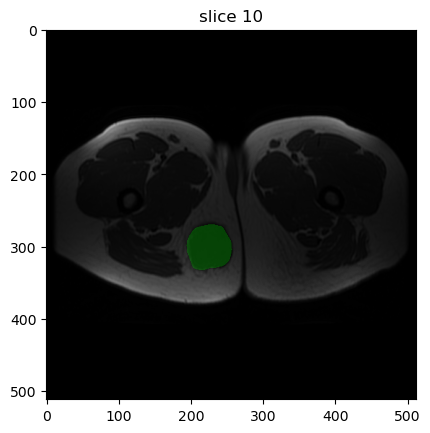

In [5]:
image, mask = images[0]
image[0].show(mask=mask[0], slice_id=10)

Though just an image is shown here, executing this code outside of a Jupyter Notebook will start an interactive plotter that can be scrolled through.

The T1-weighted image appears as expected: muscle tissue appears grey, and fatty tissue appears bright. The `GTV_Mass` segmentation mask covers the tumour -- use `image[0].show()` to view the image without a mask.

## Assessing image metadata

Image metadata are important for understanding the image and how it was acquired and reconstructed. MIRP allows for exporting image metadata from DICOM and other image formats, though for non-DICOM formats metadata will be considerably more limited.

In [6]:
from mirp import extract_image_parameters

extract_image_parameters(
    image=os.path.join(save_dir, "sts_images"),
    image_sub_folder=os.path.join("mr_t1", "image")
)

,sample_name,modality,dir_path,spacing_z,spacing_y,spacing_x,file_name,study_description,series_description,acquisition_time,series_instance_uid,frame_of_reference_uid,scanner_type,manufacturer,image_type,scanning_sequence,scanning_sequence_variant,image_index
0,STS_001,mr,sts_images\STS_001\mr_t1\image,5.2,0.390625,0.390625,1-40.dcm,^THIGH,AXIAL SE T1 - RESEARCH,2000-09-03 11:10:33.000876,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,1.3.6.1.4.1.14519.5.2.1.5168.1900.178691248814...,Avanto,SIEMENS,"['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM']",SE,"['SK', 'SP', 'OSP']",0
1,STS_002,mr,sts_images\STS_002\mr_t1\image,7.0,0.892857,0.892857,1-01.dcm,L-SPINE,AXT1,2006-01-03 14:19:40.000530,1.3.6.1.4.1.14519.5.2.1.5168.1900.103003228939...,1.3.6.1.4.1.14519.5.2.1.5168.1900.188414386222...,Intera,Philips Medical Systems,"['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']",SE,OSP,1
2,STS_003,mr,sts_images\STS_003\mr_t1\image,7.0,0.781300,0.781300,1-36.dcm,MRI PELVIS C- C,AX T1,2005-03-30 11:28:05.000000,1.3.6.1.4.1.14519.5.2.1.5168.1900.900154069973...,1.3.6.1.4.1.14519.5.2.1.5168.1900.179145981196...,Signa HDxt,GE MEDICAL SYSTEMS,"['ORIGINAL', 'PRIMARY', 'OTHER']",SE,SK,2


Only known metadata are shown. For example, magnetic field strength was not present in the image metadata in this example.

The metadata have important implications for the image processing:

- The in-plane resolution is much higher than the distance between slices. This suggests that features should be computed by slice, instead in 3D.
- The in-plane resolution differs between patients. This suggests that the images should be resampled to isotropic pixel sizes, e.g. 1.0 by 1.0 mm.
- All three images were recorded in different scanners. This suggests that MR intensities cannot be compared between patients, and should be standardised.

## Computing features

The presented metadata suggest that image processing is required to make the MR images more comparable between patients. We will define three image processing steps:

1. Image processing and feature computation are performed by slice (`by_slice=True`) due to large distances between image slices.
2. In-plane resolution is resampled to 1.0 by 1.0 mm (`new_spacing=1.0`).
3. Intensities are normalised, here using *z-normalisation* (`intensity_normalisation="standardisation"`).

In addition, we need to define parameters related to intensity discretisation for computing histogram-based and texture features. Since intensities were normalised using *z-normalisation*, we will use a *fixed bin number* algorithm (`base_discretisation_method="fixed_bin_number"`) with 16 bins (`base_discretisation_n_bins=16`).

Many more parameters can be specified, see [Configure the image processing and feature extraction workflow](https://oncoray.github.io/mirp/configuration.html).

In [7]:
import pandas as pd
from mirp import extract_features

features = extract_features(
    image=os.path.join(save_dir, "sts_images"),
    image_sub_folder=os.path.join("mr_t1", "image"),
    mask=os.path.join(save_dir, "sts_images"),
    mask_sub_folder=os.path.join("mr_t1", "mask"),
    roi_name="GTV_Mass",
    by_slice=True,
    intensity_normalisation="standardisation",
    new_spacing=1.0,
    base_discretisation_method="fixed_bin_number",
    base_discretisation_n_bins=16
)

pd.concat(features)

INFO	: MainProcess 	 2024-06-05 11:55:23,768 	 Initialising feature computation using mr images for STS_001.
INFO	: MainProcess 	 2024-06-05 11:55:36,474 	 Initialising feature computation using mr images for STS_002.
INFO	: MainProcess 	 2024-06-05 11:55:46,159 	 Initialising feature computation using mr images for STS_003.


,sample_name,image_file_name,image_directory,image_study_date,image_study_description,image_series_description,image_series_instance_uid,image_modality,image_pet_suv_type,image_mask_label,...,ngl_hdhge_d1_a0.0_2d_fbn_n16,ngl_glnu_d1_a0.0_2d_fbn_n16,ngl_glnu_norm_d1_a0.0_2d_fbn_n16,ngl_dcnu_d1_a0.0_2d_fbn_n16,ngl_dcnu_norm_d1_a0.0_2d_fbn_n16,ngl_dc_perc_d1_a0.0_2d_fbn_n16,ngl_gl_var_d1_a0.0_2d_fbn_n16,ngl_dc_var_d1_a0.0_2d_fbn_n16,ngl_dc_entr_d1_a0.0_2d_fbn_n16,ngl_dc_energy_d1_a0.0_2d_fbn_n16
0,STS_001,None,sts_images\STS_001\mr_t1\image,20000903,^THIGH,AXIAL SE T1 - RESEARCH,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,mr,None,GTV_Mass,...,649.904779,685.643163,0.202679,573.379973,0.164149,1.0,2.124407,2.835808,5.207281,0.034652
0,STS_002,None,sts_images\STS_002\mr_t1\image,20060103,L-SPINE,AXT1,1.3.6.1.4.1.14519.5.2.1.5168.1900.103003228939...,mr,None,GTV_Mass,...,731.317187,232.044296,0.208755,212.059230,0.183419,1.0,3.301315,5.169630,5.048137,0.050158
0,STS_003,None,sts_images\STS_003\mr_t1\image,20050330,MRI PELVIS C- C,AX T1,1.3.6.1.4.1.14519.5.2.1.5168.1900.900154069973...,mr,None,GTV_Mass,...,608.689328,472.701740,0.345461,334.257475,0.238191,1.0,3.232402,5.422279,4.222418,0.132661


This results in a `pandas.DataFrame` that has a row per image and mask. The first several columns contain parameters related to that image and mask, and how these were processed. After these, feature values are shown. These can be used for, e.g., machine learning using [scikit-learn](https://scikit-learn.org/stable/) or [familiar](https://cran.r-project.org/web/packages/familiar/index.html).

## References

1. Vallières, Martin, Freeman, Carolyn R., Skamene, Sonia R., & El Naqa, Issam. (2015). A radiomics model from joint FDG-PET and MRI texture features for the prediction of lung metastases in soft-tissue sarcomas of the extremities (Soft-tissue-Sarcoma) \[Dataset\]. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS